In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [2]:
import pickle
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

In [3]:
from keras.layers import MaxPooling2D, GlobalAveragePooling2D

In [4]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def populate_clean(df, cleanFolderPath, wavfilesPath):
#     i=0
    for f in tqdm(df.index):
#         i+=1
#         print(i)
        rate, signal = wavfile.read(wavfilesPath+f)
        mask = envelope(signal, rate, 20)

        wavfile.write(cleanFolderPath+f, rate, signal[mask])

#Configuration of data
class Config:
    def __init__(self, nfeat=128, nfft=2048, rate=44100):
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/5)# Each sample no contains (44100/5) data points which are passed to mel    

In [5]:
#===============================================================================
# Builds MFCC by taking all the wav files in clean folder
#===============================================================================
def build_mfcc(config, cleanFolderPath, df, classes, mode):
    c = config
    X = []
    y = []
    _min, _max = float('inf'), float('-inf')
    for f in tqdm(df.index):
        rate, wav = wavfile.read(cleanFolderPath+f)
        wav = wav.astype(float)
        label = df.at[f, 'label']
        step = c.step
        manual = int(df.at[f, 'manually_verified'])
#         print(mode, manual)
        if len(wav)<1000:
            continue 
        if mode==1 and manual!=1:
            continue
        for i in range(0, len(wav), step):
#             print("In")
            partition = i+step
            if step > wav.shape[0]:
                signal = np.zeros((step, 1))
                signal[:wav.shape[0], :] = wav.reshape(-1, 1)
                X_mfcc = mfcc(signal, rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            elif partition > len(wav):
                X_mfcc = mfcc(wav[-step:], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            else:
                X_mfcc = mfcc(wav[i:i+step], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            _min = min(np.amin(X_mfcc), _min)
            _max = max(np.amax(X_mfcc), _max)
            X.append(X_mfcc)
            y.append(classes.index(label)) # Assigning an integer for a string
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
#     print(_min, _max)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=41) # Converts to onehot vector
    return X, y


#===============================================================================
# Builds MFCC by taking all the wav files in clean folder
#===============================================================================
# def build_mfcc(config, cleanFolderPath, df, classes, mode):
#     c = config
#     X = []
#     y = []
#     _min, _max = float('inf'), float('-inf')
#     for f in tqdm(df.index):
# #         manual = int(df.at[f, 'manually_verified'])
# #         if mode==1 and manual!=1:
# #             continue
#         rate, wav = wavfile.read(cleanFolderPath+f)
#         wav = wav.astype(float)
#         label = df.at[f, 'label']
#         step = c.step
        
# #         print(mode, manual)
#         if len(wav)<1000:
#             continue 

#         for i in range(0, len(wav), step):
# #             print("In")
#             partition = i+step
#             if step > wav.shape[0]:
#                 signal = np.zeros((step, 1))
#                 signal[:wav.shape[0], :] = wav.reshape(-1, 1)
#                 X_mfcc = mfcc(signal, rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
#             elif partition > len(wav):
#                 X_mfcc = mfcc(wav[-step:], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
#             else:
#                 X_mfcc = mfcc(wav[i:i+step], rate, numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
#             _min = min(np.amin(X_mfcc), _min)
#             _max = max(np.amax(X_mfcc), _max)
# #             print(X_mfcc.shape)
# #             input()
#             X.append(X_mfcc)
#             y.append(classes.index(label)) # Assigning an integer for a string
#     X, y = np.array(X), np.array(y)
#     X = (X - _min) / (_max - _min)
# #     print(_min, _max)
#     X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
#     y = to_categorical(y, num_classes=len(classes)) # Converts to onehot vector
#     return X, y


In [4]:
# #===============================================================================
# # CNN
# #===============================================================================
# def convolutionModel(input_shape):
#     model = Sequential()
#     model.add(Conv2D(16, (5, 5), activation='relu', strides=(2, 2),
#                      padding='same', input_shape=input_shape))
#     model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
#                      padding='same'))
#     model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
#                      padding='same'))
#     model.add(MaxPool2D((2,2)))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(41, activation='softmax'))
#     model.summary()
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['acc'])
#     return model

In [6]:
# def convolutionModel2(input_shape):
#     model = Sequential()
#     model.add(Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same', input_shape=input_shape))
# #     model.add(MaxPool2D((2,2)))
# #     model.add(BatchNormalization())
    
#     model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# #     model.add(MaxPool2D((2,2)))
# #     model.add(BatchNormalization())
    
#     model.add(Conv2D(192, (3, 3), activation='relu', strides=(1, 1), padding='same'))
#     model.add(MaxPool2D((2,2)))
# #     model.add(Dropout(0.5))
# #     model.add(BatchNormalization())
    
#     model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# #     model.add(Dropout(0.5))
# #     model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# #     model.add(MaxPool2D((2,2)))
#     model.add(BatchNormalization())
    
# #     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
# #     model.add(BatchNormalization())
#     model.add(Dense(256, activation='relu'))
# #     model.add(Dropout(0.5))
#     model.add(Dense(41, activation='softmax'))
#     model.summary()
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['acc'])
#     return model

In [6]:
#     path = "E:/Dataset/"
wavfilesPathTrain = "FSDKaggle2018.audio_train/"
wavfilesPathTest = "FSDKaggle2018.audio_test/"
#     csvFilePaths = path+"FSDKaggle2018Meta/"
cleanFolderPathTrain = "clean_train_highmel/"
cleanFolderPathTest = "clean_test_highmel/"

reqLabels = ["Saxophone", "Violin_or_fiddle", "Hi-hat", "Snare_drum", "Acoustic_guitar", "Double_bass", "Cello", "Bass_drum", "Flute", "Clarinet", "Chime", "Cowbell", "Electric_piano", "Glockenspiel", "Gong", "Harmonica", "Oboe", "Tambourine", "Trumpet"]

## Now populating Training cleaned data
dfTrain = pd.read_csv('train_post_competition.csv')
dfTrain.set_index('fname', inplace=True)

for f in dfTrain.index:
    lab = dfTrain.at[f, 'label']
    manual = dfTrain.at[f, 'manually_verified']
    if (lab not in reqLabels) or (manual == 0):
        dfTrain.drop(f, inplace = True)
        
print(dfTrain)
populate_clean(dfTrain, cleanFolderPathTrain, wavfilesPathTrain)

## Now populating testing cleaned data
dfTest = pd.read_csv('test_post_competition_scoring_clips.csv')
dfTest.set_index('fname', inplace=True)
populate_clean(dfTest, cleanFolderPathTest, wavfilesPathTest)

## Now updating MFCC
config = Config()
classes = list(np.unique(dfTrain.label))
mode = 1 # Set this to be 1 to run on wavfiles evaluated manually
XTrain, yTrain = build_mfcc(config, cleanFolderPathTrain, dfTrain, classes, mode)

  0%|          | 1/2068 [00:00<05:16,  6.53it/s]

                     label  manually_verified  freesound_id  \
fname                                                         
001ca53d.wav     Saxophone                  1        358827   
0033e230.wav  Glockenspiel                  1        325017   
00353774.wav         Cello                  1        195688   
006f2f32.wav        Hi-hat                  1        138726   
0091fc7f.wav         Cello                  1        358283   
...                    ...                ...           ...   
ff3f21e7.wav    Snare_drum                  1         13208   
ff462e1b.wav       Cowbell                  1         75338   
ff752a0c.wav      Clarinet                  1        248461   
ff9eae6f.wav          Gong                  1        222342   
ffc92b01.wav         Cello                  1        247544   

                         license  
fname                             
001ca53d.wav         Attribution  
0033e230.wav         Attribution  
00353774.wav         Attribution  
006f2

 42%|████▏     | 871/2068 [01:02<01:26, 13.88it/s]


KeyboardInterrupt: 

In [49]:
for f in dfTest.index:
    lab = dfTest.at[f, 'label']
    if (lab not in reqLabels):
        dfTest.drop(f, inplace = True)

In [51]:
classes_test = list(np.unique(dfTest.label))
mode = 1 # Set this to be 1 to run on wavfiles evaluated manually
XTest, yTest = build_mfcc(config, cleanFolderPathTest, dfTest, classes_test, mode)

100%|██████████| 890/890 [02:01<00:00,  7.31it/s]


In [52]:
with open('XTest_mfcc_highmel.data.pickle', 'wb') as filehandle:
    pickle.dump(XTest, filehandle)
with open('yTest_mfcc_highmel.data.pickle', 'wb') as filehandle:
    pickle.dump(yTest, filehandle)

y_flat_test = np.argmax(yTest, axis=1)
# input_shape = (XTrain.shape[1], XTrain.shape[2], 1)
class_weight_test = compute_class_weight('balanced', np.unique(y_flat_test), y_flat_test)

In [54]:
needed_2 = np.zeros((XTest.shape[0], XTest.shape[1], 32))
needed2 = np.reshape(XTest, (XTest.shape[0], XTest.shape[1], XTest.shape[2]))
needed_2[:,:,:19] = needed2

XTestR = np.zeros((XTest.shape[0], XTest.shape[1], 32, 3))
XTestR[:, :, :, 0] = needed_2
XTestR[:, :, :, 1] = needed_2
XTestR[:, :, :, 2] = needed_2
XTest = XTestR

In [12]:
needed_1 = np.zeros((XTrain.shape[0], XTrain.shape[1], 32))
needed = np.reshape(XTrain, (XTrain.shape[0], XTrain.shape[1], 19))
needed_1[:,:,:19] = needed

XTrainR = np.zeros((XTrain.shape[0], XTrain.shape[1], 32, 3))
XTrainR[:, :, :, 0] = needed_1
XTrainR[:, :, :, 1] = needed_1
XTrainR[:, :, :, 2] = needed_1
XTrain = XTrainR

In [55]:
input_shape = (XTrain.shape[1], XTrain.shape[2], 3)

In [16]:
def vgg16(input_shape, numClasses):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
    i = 0
    for layer in vgg_model.layers:
        if i>10 and i<=17:
            layer.trainable = True
        else:
            layer.trainable = False
        i+=1
#     print(vgg_model.summary())
    model = Sequential()
    model.add(vgg_model)
     
    model.add(Flatten())
    model.add(Dense(512, activation='relu', input_dim=4 * 4 * 512))
    model.add(Dropout(0.5))
    class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
    model.add(Dense(256, activation='relu', input_dim=512))
     
#     model.add(layers.Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    model.summary()
    sgd = SGD(lr=0.005, decay=0.005, momentum=0.9)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ["accuracy"])
    return model

In [20]:
model = vgg16(input_shape, len(classes))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 19)                4883      
Total params: 15,899,987
Trainable params: 14,164,499
Non-trainable params: 1,735,488
__________________________________

In [22]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
checkpoint = ModelCheckpoint('vgg_highmel.h5', period=1)
model.fit(XTrain, yTrain, epochs=40, batch_size=512, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])
model.save("vgg_highmel.h5")

Train on 40877 samples, validate on 7214 samples
Epoch 1/40
40877/40877 [==============================] - 232s 6ms/step - loss: 2.3079 - accuracy: 0.2653 - val_loss: 1.9907 - val_accuracy: 0.3355
Epoch 2/40
40877/40877 [==============================] - 225s 6ms/step - loss: 1.7826 - accuracy: 0.4201 - val_loss: 1.7528 - val_accuracy: 0.4483
Epoch 3/40
40877/40877 [==============================] - 220s 5ms/step - loss: 1.4802 - accuracy: 0.5148 - val_loss: 1.4943 - val_accuracy: 0.5035
Epoch 4/40
40877/40877 [==============================] - 221s 5ms/step - loss: 1.3193 - accuracy: 0.5674 - val_loss: 1.4572 - val_accuracy: 0.5241
Epoch 5/40
40877/40877 [==============================] - 223s 5ms/step - loss: 1.1997 - accuracy: 0.6040 - val_loss: 1.4040 - val_accuracy: 0.5469
Epoch 6/40
40877/40877 [==============================] - 223s 5ms/step - loss: 1.1000 - accuracy: 0.6405 - val_loss: 1.3501 - val_accuracy: 0.5697
Epoch 7/40
40877/40877 [==============================] - 224s 

In [56]:
yPred = model.predict(XTest)
yPred_flat = np.argmax(yPred, axis=1)

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [59]:
print(classification_report(y_flat_test,yPred_flat))

              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1407
           1       0.82      0.49      0.62       189
           2       0.53      0.51      0.52      1447
           3       0.61      0.59      0.60      1234
           4       0.69      0.77      0.73      1690
           5       0.65      0.28      0.39       236
           6       0.42      0.29      0.34       540
           7       0.74      0.64      0.68      1610
           8       0.74      0.75      0.74      1856
           9       0.43      0.38      0.40       479
          10       0.52      0.63      0.57       764
          11       0.68      0.61      0.65       775
          12       0.53      0.36      0.43       207
          13       0.47      0.60      0.53       579
          14       0.78      0.76      0.77      3456
          15       0.35      0.49      0.41       106
          16       0.90      0.91      0.91       302
          17       0.82    

In [61]:
cm_20 = confusion_matrix(y_flat_test,yPred_flat)
df_cm = pd.DataFrame(cm_20, index = list(set(yPred_flat)),
                  columns = list(set(yPred_flat)))

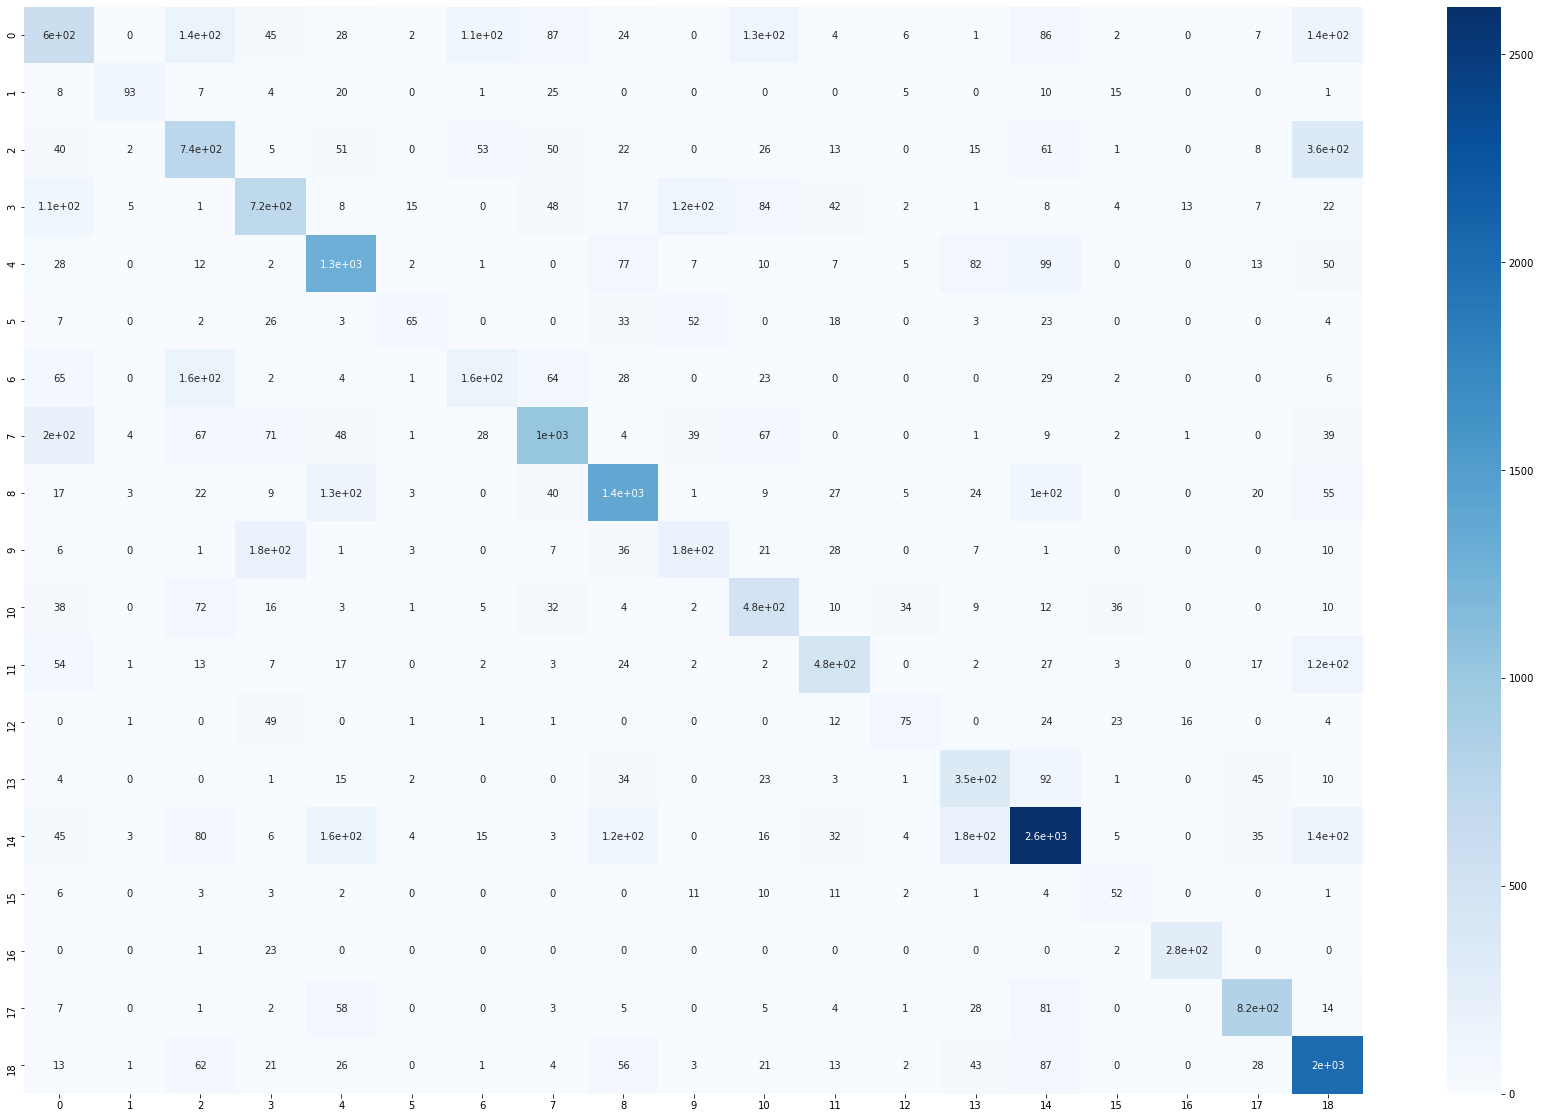

In [62]:
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True,cmap='Blues')

In [18]:
def convolutionModel2(input_shape, nclasses):
    model = Sequential()
    model.add(Conv2D(64, (5, 5), activation='relu', strides=(2,2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
#     model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3,3), activation='relu', strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(192, (3,3), activation='relu', strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(nclasses, activation='softmax'))
    
    sgd = SGD(lr=0.0005, decay=1e-3, momentum=0.9)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ["accuracy"])
    return model

In [ ]:
XTrainR1 = np.zeros((XTrain.shape[0], XTrain.shape[1], XTrain.shape[2], 1))
XTrainR1[:, :, :, 0] = needed_1

In [46]:
input1Shape = (XTrainR1.shape[1], XTrainR1.shape[2], 1)
model2 = convolutionModel2(input1Shape, len(reqLabels))
checkpoint = ModelCheckpoint('ConvModel2.h5', period=1)
model2.fit(XTrainR1, yTrain, epochs=40, batch_size=512, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])
model2.save("ConvModel2.h5")

Train on 40877 samples, validate on 7214 samples
Epoch 1/40
40877/40877 [==============================] - 143s 3ms/step - loss: 2.5289 - accuracy: 0.2347 - val_loss: 3.0033 - val_accuracy: 0.0096
Epoch 2/40
40877/40877 [==============================] - 137s 3ms/step - loss: 1.9163 - accuracy: 0.4212 - val_loss: 2.9583 - val_accuracy: 0.0918
Epoch 3/40
40877/40877 [==============================] - 141s 3ms/step - loss: 1.5585 - accuracy: 0.5331 - val_loss: 2.9808 - val_accuracy: 0.1404
Epoch 4/40
40877/40877 [==============================] - 146s 4ms/step - loss: 1.3319 - accuracy: 0.6091 - val_loss: 3.1965 - val_accuracy: 0.1404
Epoch 5/40
40877/40877 [==============================] - 137s 3ms/step - loss: 1.1747 - accuracy: 0.6523 - val_loss: 3.5284 - val_accuracy: 0.1404
Epoch 6/40
40877/40877 [==============================] - 139s 3ms/step - loss: 1.0726 - accuracy: 0.6839 - val_loss: 3.3849 - val_accuracy: 0.1797
Epoch 7/40
40877/40877 [==============================] - 139s 

In [64]:
XTestR1 = np.zeros((XTest.shape[0], XTest.shape[1], XTest.shape[2], 1))
XTestR1[:, :, :, 0] = needed_2

In [65]:
yPred_cnn = model2.predict(XTestR1)
yPred_flat_cnn = np.argmax(yPred_cnn, axis=1)

In [66]:
print(classification_report(y_flat_test,yPred_flat_cnn))

              precision    recall  f1-score   support

           0       0.45      0.47      0.46      1407
           1       1.00      0.03      0.06       189
           2       0.85      0.49      0.62      1447
           3       0.57      0.52      0.55      1234
           4       0.41      0.90      0.56      1690
           5       0.94      0.20      0.33       236
           6       0.95      0.18      0.30       540
           7       0.63      0.70      0.66      1610
           8       0.91      0.75      0.82      1856
           9       0.50      0.38      0.43       479
          10       0.72      0.30      0.43       764
          11       0.66      0.40      0.50       775
          12       0.64      0.21      0.32       207
          13       0.61      0.69      0.65       579
          14       0.74      0.85      0.79      3456
          15       0.15      0.62      0.24       106
          16       0.90      0.57      0.70       302
          17       0.76    

In [67]:
cm_20_cnn = confusion_matrix(y_flat_test,yPred_flat_cnn)
df_cm_cnn = pd.DataFrame(cm_20_cnn, index = list(set(yPred_flat_cnn)),
                  columns = list(set(yPred_flat_cnn)))

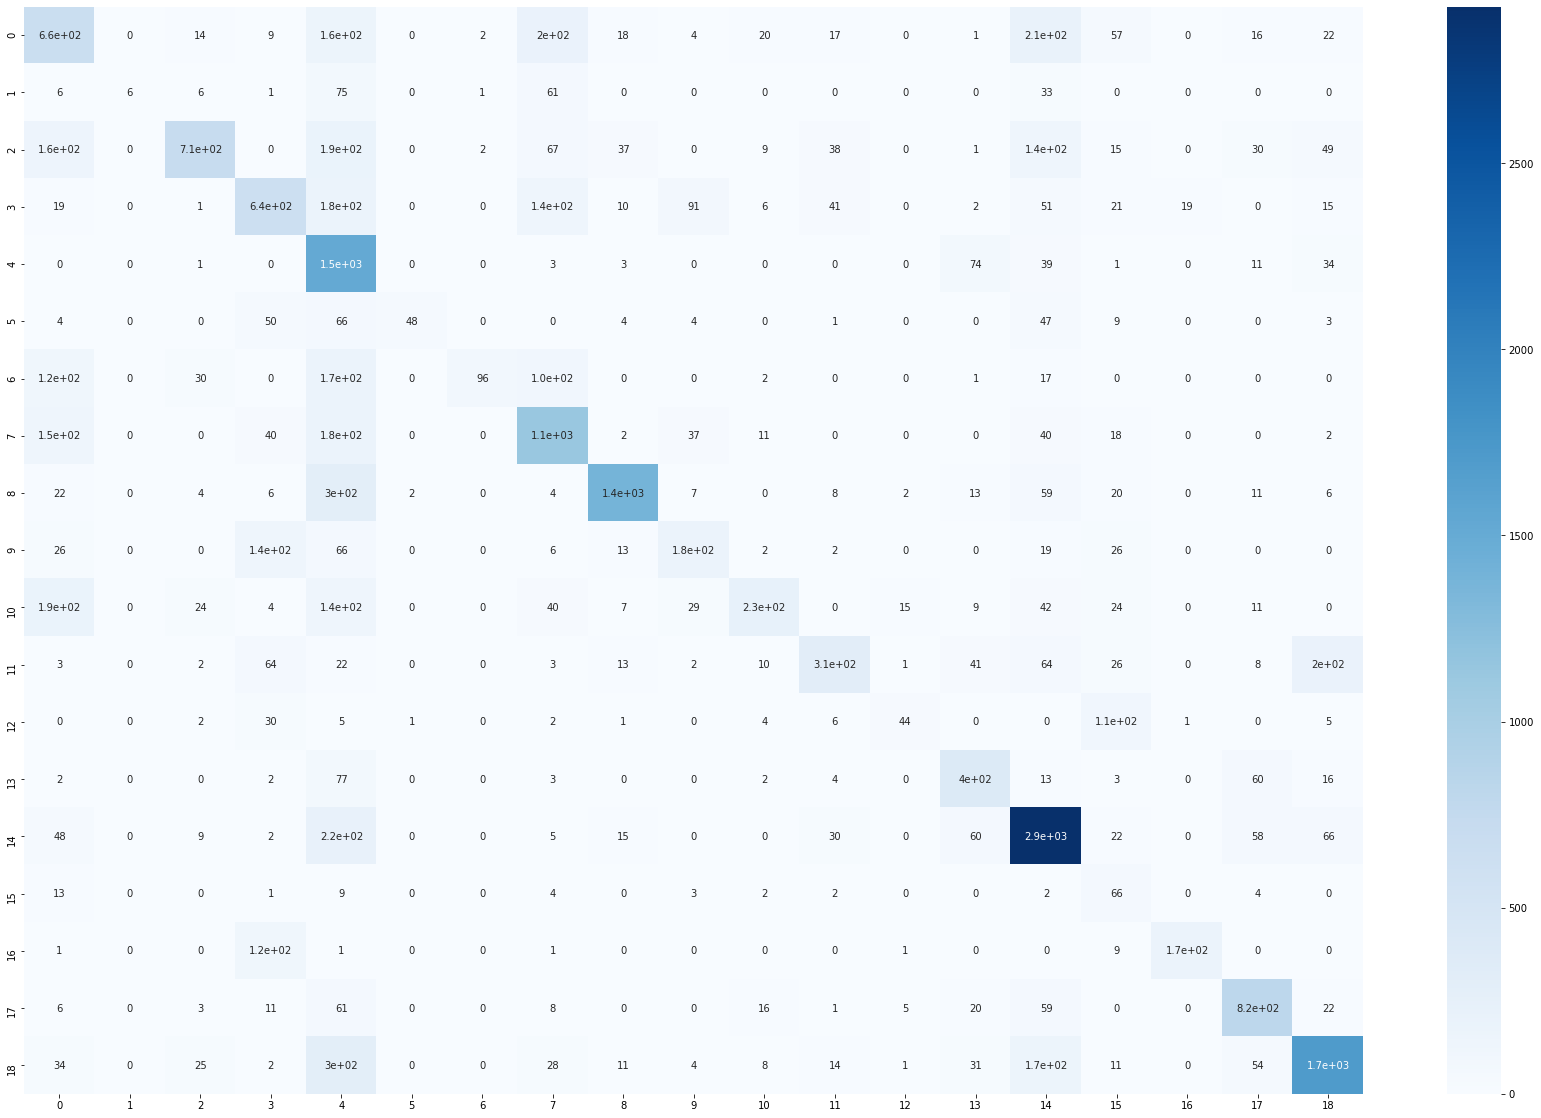

In [68]:
plt.figure(figsize = (30,20))
sn.heatmap(df_cm_cnn, annot=True,cmap='Blues')

In [76]:
def convolutionModel3(input_shape, nclasses):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    # Display model architecture summary 
    model.summary()
    return model

In [77]:
from datetime import datetime
start = datetime.now()
input1Shape = (XTrainR1.shape[1], XTrainR1.shape[2], 1)
model3 = convolutionModel3(input1Shape, len(reqLabels))
checkpoint = ModelCheckpoint('ConvModel3.h5', period=1)
model2.fit(XTrainR1, yTrain, epochs=72, batch_size=256, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])
model2.save("ConvModel3.h5")
duration = datetime.now() - start
print("Training completed in time: ", duration)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 127, 31, 16)       80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 15, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 15, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 62, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 7, 32)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 31, 7, 32)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 6, 64)       

KeyboardInterrupt: 

In [7]:
XTest.shape

NameError: name 'XTest' is not defined